In [390]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from math import atan2, degrees, pi

from geopy.distance import vincenty

import seaborn as sns

import folium



### Acceptable Signal Strengths


| Signal Strength | TL        | DR                                                                                                    | Required for                                |
|-----------------|-----------|-------------------------------------------------------------------------------------------------------|---------------------------------------------|
| -30 dBm         | Amazing   | Max achievable signal strength. The client can only be a few feet from the AP to achieve this.        | Not typical or desirable in the real world. |
| -67 dBm         | Very Good | Minimum signal strength for applications that require very reliable, timely delivery of data packets. | VoIP/VoWiFi, streaming video                |
| -70 dBm         | Okay      | Minimum signal strength for reliable packet delivery.                                                 | Email, web.                                 |
| -80 dBm         | Not Good  | Minimum signal strength for basic connectivity. Packet delivery may be unreliable                     | N/A                                         |
| -90 dBm         | Unusable  | Approaching or drowning in the noise floor. Any functionality is highly unlikely.                     | N/A                                         |

In [2]:
# load train and test data
df_mess_train = pd.read_csv('mess_train_list.csv') # train set
df_mess_test = pd.read_csv('mess_test_list.csv') # test set
pos_train = pd.read_csv('pos_train_list.csv') # position associated to train set

In [3]:
print()

## Exploration des données BS sur les set de train et de test

### Aperçu des stations

In [4]:
df_mess_train[0:10]

,objid,bsid,did,nseq,rssi,time_ux,bs_lat,bs_lng
0,573bf1d9864fce1a9af8c5c9,2841,473335.0,0.5,-121.500000,1.463546e+12,39.617794,-104.954917
1,573bf1d9864fce1a9af8c5c9,3526,473335.0,2.0,-125.000000,1.463546e+12,39.677251,-104.952721
2,573bf3533e952e19126b256a,2605,473335.0,1.0,-134.000000,1.463547e+12,39.612745,-105.008827
3,573c0cd0f0fe6e735a699b93,2610,473953.0,2.0,-132.000000,1.463553e+12,39.797969,-105.073460
4,573c0cd0f0fe6e735a699b93,3574,473953.0,1.0,-120.000000,1.463553e+12,39.723151,-104.956216
5,573c0cd0f0fe6e735a699b93,8474,473953.0,2.0,-100.000000,1.463553e+12,39.732045,-104.973651
6,573c1272f0fe6e735a6cb8bd,1859,476512.0,1.0,-123.333333,1.463555e+12,39.704887,-105.016392
7,573c1272f0fe6e735a6cb8bd,2605,476512.0,1.0,-129.666667,1.463555e+12,39.612745,-105.008827
8,573c1272f0fe6e735a6cb8bd,3025,476512.0,1.0,-123.666667,1.463555e+12,39.654682,-105.043685
9,573c1272f0fe6e735a6cb8bd,8082,476512.0,1.0,-133.000000,1.463555e+12,39.495225,-105.053109


In [5]:
pos_train[0:10]

,lat,lng
0,39.606690,-104.958490
1,39.606690,-104.958490
2,39.637741,-104.958554
3,39.730417,-104.968940
4,39.730417,-104.968940
5,39.730417,-104.968940
6,39.693102,-105.006995
7,39.693102,-105.006995
8,39.693102,-105.006995
9,39.693102,-105.006995


In [7]:
pos_train.describe()

,lat,lng
count,39250.000000,39250.000000
mean,39.783333,-105.056343
std,0.206262,0.162954
min,35.770683,-107.630679
25%,39.708599,-105.060463
50%,39.776882,-105.039440
75%,39.805279,-105.018730
max,43.140387,-102.094289


### BSID du train et du test set

In [8]:
listOfBs = np.union1d(np.unique(df_mess_train['bsid']), np.unique(df_mess_test['bsid'])) 
# determine all Base stations that received at least 1 message

In [9]:
print("|Nombre total de stations             |", len(listOfBs))
print("|Nombre de stations dans le train set |", len(np.unique(df_mess_train['bsid'])))
print("|Nombre de stations dans le test set  |", len(np.unique(df_mess_test['bsid'])))

|Nombre total de stations             | 259
|Nombre de stations dans le train set | 251
|Nombre de stations dans le test set  | 168


##### Conclusion: 8 stations du test set n'apparaissent pas dans le train set.

In [10]:
print("|Nombre d'observations (objid) dans le train set |", len(np.unique(df_mess_train['objid'])))
print("|Nombre d'observations (objid) dans le test set  |", len(np.unique(df_mess_test['objid'])))
print("|Taille du train set                             |", len(df_mess_train))
print("|Taille du test set                              |", len(df_mess_test))

|Nombre d'observations (objid) dans le train set | 6068
|Nombre d'observations (objid) dans le test set  | 5294
|Taille du train set                             | 39250
|Taille du test set                              | 29286


In [11]:
29 / 5.3

5.471698113207547

##### Conclusion: environ 6 mesures par observation

### Comment sont répartis les niveaux de signal reçu ?

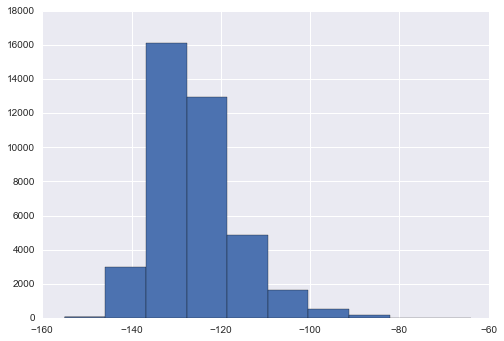

In [12]:
df_mess_train['rssi'].hist()

### Comment sont réparties les stations du train set et du test set ?

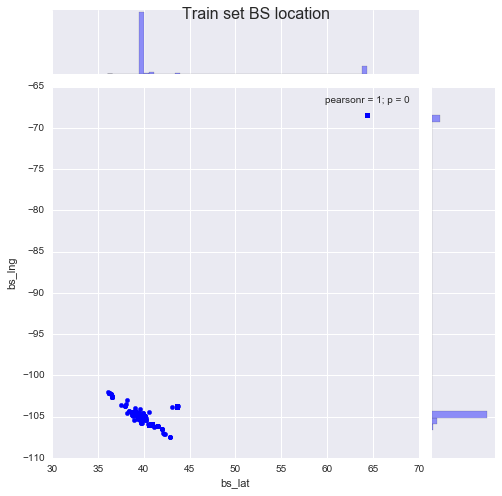

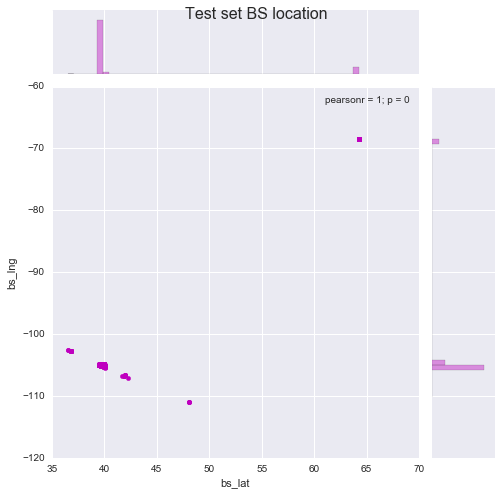

In [13]:
g = sns.jointplot("bs_lat", "bs_lng", data=df_mess_train, color="b", size=7)
g.fig.suptitle("Train set BS location", fontsize=16) 
g = sns.jointplot("bs_lat", "bs_lng", data=df_mess_test, color="m", size=7)
g.fig.suptitle("Test set BS location", fontsize=16) 

##### Les stations semblent être regroupées dans le même zone géographique, à quelques exceptions.

### Affichons sur une carte l'emplacement d'un échantillons de stations du train set pour mieux percevoir l'effet observé plus haut.

In [331]:
my_map = folium.Map()

df_station_train = df_mess_train.drop_duplicates('bsid')[['bs_lat', 'bs_lng']]

count = 0
for index, row in df_station_train.iterrows():
    
    if row['bs_lat'] < 62:
        folium.Marker([row['bs_lat'],row['bs_lng']]).add_to(my_map)
    else:
        # But display all stations on atypic places
        folium.Marker([row['bs_lat'],row['bs_lng']], popup="Atypic", icon=folium.Icon(color='red')).add_to(my_map)
        

In [332]:
# Final rendering
my_map

In [330]:
listOfStangeBs = np.unique(df_mess_train[df_mess_train['bs_lat'] > 62]['bsid'])
print("List of stange Stations: ", listOfStangeBs)

List of stange Stations:  [ 1092  1594  1661  1743  1772  1796  1854  2293  2707  2943  4123  4129
  4156  4959  4987  4993  7248  8355  8449  8451  8560  9784 10151 10162
 10999 11007 11951]


#### Les stations sont regroupées dans le même zone géographique, à quelques exceptions. Observons désormais l'emplacement des devices associés.

## Exploration de l'emplacement des devices (pos_train)

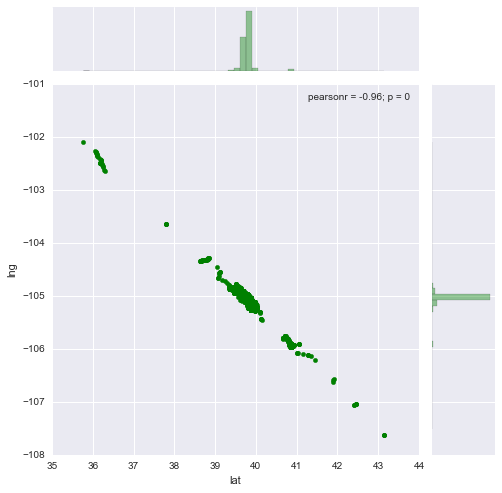

In [16]:
g = sns.jointplot("lat", "lng", data=pos_train, color="g", size=7)

On constate que ces points sont regroupés. A la lumière des coordonnées des BS, cela nous pousse à éliminer les points des BS qui nous semblent atypiques.

In [336]:
my_map = folium.Map()

df_devices_train = pos_train.drop_duplicates(['lat', 'lng'])


for index, row in df_devices_train.iterrows():
    # Display only 1 on 20 station
    if index % 10 == 0:
        folium.Marker([row['lat'],row['lng']], icon=folium.Icon(color='green')).add_to(my_map)

In [391]:
#my_map

##### Conclusion: l'ensemble des devices est regroupé dans la même zone géographique. En particulier, aucun d'entre eux n'est situé dans la zone "atypique" où se trouvent quelques stations. 

# Préparation des données d'entraînement

L'idée est d'effectuer les traitements suivants: 
1. Rajout d'une colonne qui donne la distance entre la BS et le Device.
2. Transformation du niveau de signal en une grandeur équivalente à une distance.

In [369]:
df_merge = pd.concat([df_mess_train, pos_train], axis=1)

In [370]:
def f(x):
    return vincenty((x[6], x[7]), (x[8], x[9])).miles

In [392]:
def angle(x):
    dx = x[6] - x[8]
    dy = x[7] - x[9]
    return atan2(-dy,dx)

In [371]:
# Adding vincenty distance from devices to base stations
df_merge['dist'] = df_merge.apply(f, axis=1)

In [393]:
# Adding vincenty distance from devices to base stations
df_merge['angle'] = df_merge.apply(angle, axis=1)

In [396]:
# d = 10 ^ ((P-Rssi) / 10n) (n ranges from 2 to 4)
# https://forums.estimote.com/t/use-rssi-measure-the-distance/3665
# The idea is to create a column proportional to distance.
df_merge['d_rssi'] = 10 ** ((30 - df_merge['rssi']) / 100)

In [397]:
df_merge.describe()

,bsid,did,nseq,rssi,time_ux,bs_lat,bs_lng,lat,lng,dist,d_rssi,angle
count,39250.000000,3.925000e+04,39250.000000,39250.000000,3.925000e+04,39250.000000,39250.000000,39250.000000,39250.000000,39250.000000,39250.000000,39250.000000
mean,4533.774752,4.835932e+05,1.043541,-125.863580,1.473368e+12,42.554998,-100.969685,39.783333,-105.056343,255.229467,36.961027,-0.102711
std,2570.495638,9.893140e+04,0.563540,9.226500,5.506910e+09,7.722787,11.522732,0.206262,0.162954,705.754365,7.134208,1.611408
min,879.000000,4.732880e+05,0.000000,-155.000000,1.463546e+12,36.053394,-107.463146,35.770683,-107.630679,0.016510,8.709636,-3.141483
25%,2790.000000,4.761230e+05,1.000000,-132.500000,1.468410e+12,39.747448,-105.074287,39.708599,-105.060463,1.400517,32.359366,-1.214249
50%,3559.000000,4.763150e+05,1.000000,-127.333333,1.473444e+12,39.793585,-105.043685,39.776882,-105.039440,2.911849,37.439784,-0.144416
75%,7456.000000,4.766090e+05,1.500000,-121.000000,1.479118e+12,39.838740,-104.998429,39.805279,-105.018730,6.107650,42.169650,1.159507
max,11951.000000,1.747448e+06,2.000000,-64.000000,1.481143e+12,64.300000,-68.500000,43.140387,-102.094289,2254.742248,70.794578,3.141545


## Affichons la répartitions des distances BS - Devices (miles)

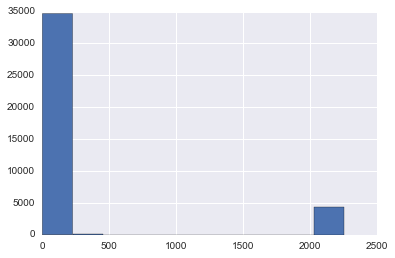

In [398]:
df_merge['dist'].hist()

### On retrouve les distances aberrantes observées auparavant.

In [399]:
df_merge['dist'].quantile(0.88)

20.673322853507102

### Aperçu des positions géographiques des devices

## "Clean" des données d'apprentissage

In [400]:
df_merge_clean = df_merge[df_merge['dist'] < 100]

In [401]:
df_merge_not_clean = df_merge[df_merge['dist'] >= 100]

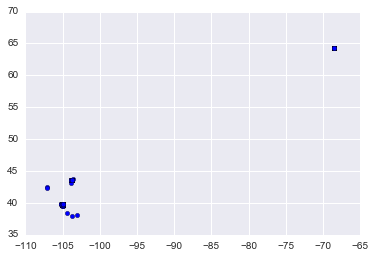

In [402]:
plt.scatter(df_merge_not_clean.bs_lng, df_merge_not_clean.bs_lat) # plotting t,a separately 
plt.scatter(df_merge_not_clean.lng, df_merge_not_clean.lat) # plotting t,b separately 

In [403]:
df_merge_not_clean['bsid'].unique()

array([ 8355, 11007,  1594, 10151, 10162,  8451,  4993,  8560,  1156,
        1187,  2293,  4959, 10148, 10999,  1661,  8449,  4156,  4129,
        1743,  4987,  1772,  1796,  2707,  2943,  4123, 11951,  9784,
        1092,  7508,  3848,  2803,  2808,  3630,  2800,  3933,  3501,
        4013,  1443,  1854,  7248])

In [404]:
print(len(df_merge_not_clean['objid'].unique()),
len(df_merge_clean['objid'].unique()))

1897 5870


In [405]:
len(np.intersect1d(df_merge_not_clean['objid'].unique(), df_merge_clean['objid'].unique()))

1699

### Le graphique ci-dessous affiche la relation en le niveau de signal (rssi) et la distance

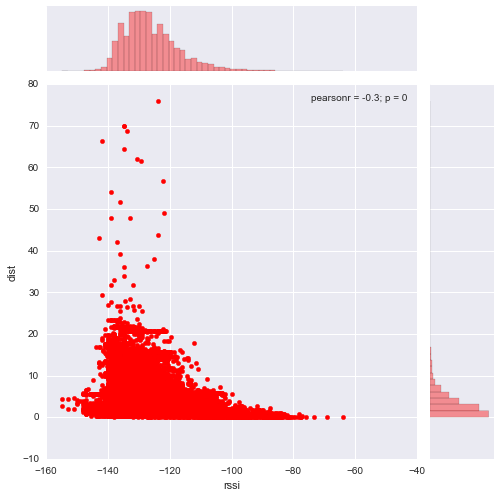

In [406]:
g = sns.jointplot("rssi", "dist", data=df_merge_clean, color="r", size=7)

### Le graphique ci-dessous affiche la relation en le niveau de signal (rssi) et la distance pour une base

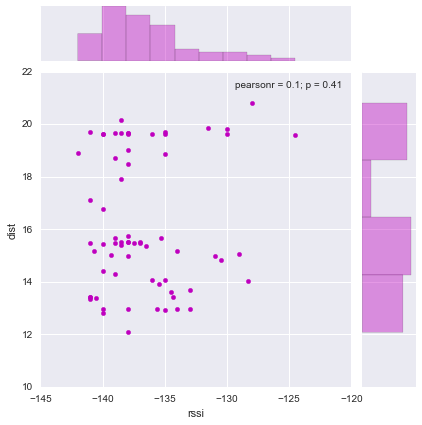

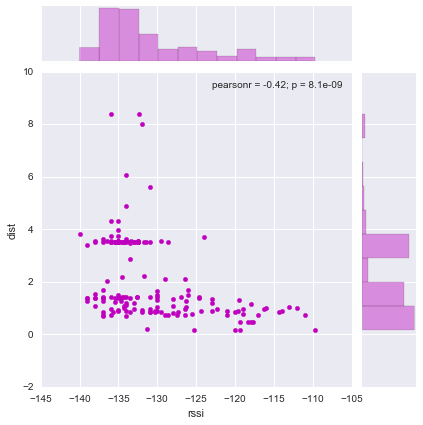

In [407]:
g = sns.jointplot("rssi", "dist", data=df_merge_clean[df_merge_clean.bsid == 1086], color="m", size=6)
g = sns.jointplot("rssi", "dist", data=df_merge_clean[df_merge_clean.bsid == 3574], color="m", size=6)

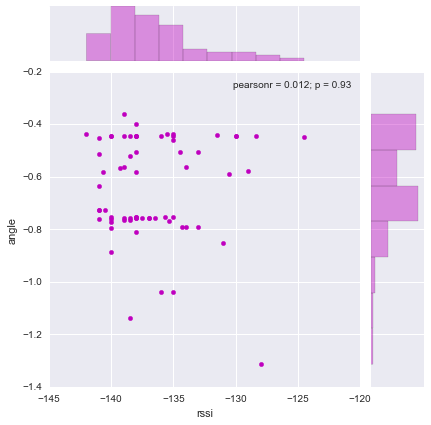

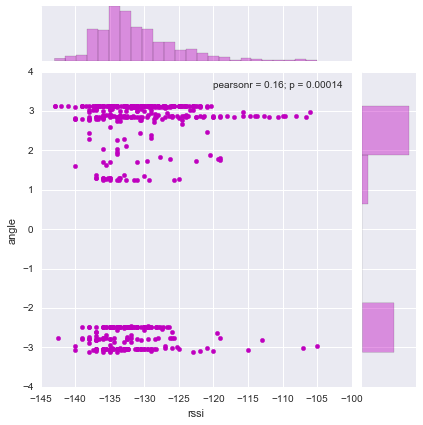

In [413]:
g = sns.jointplot("rssi", "angle", data=df_merge_clean[df_merge_clean.bsid == 1086], color="m", size=6)
g = sns.jointplot("rssi", "angle", data=df_merge_clean[df_merge_clean.bsid == 2605], color="m", size=6)

In [353]:
# sns.lmplot(x="rssi", y="dist", col="bsid", hue="bsid", data=df_merge_clean[df_merge_clean.bsid <1090],
#           col_wrap=4, ci=None, palette="muted", size=4)


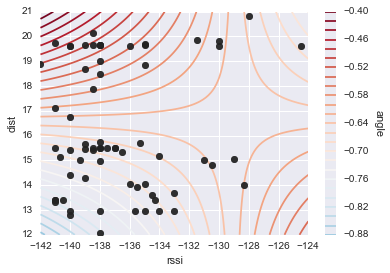

In [422]:
tmp=df_merge_clean[df_merge_clean.bsid == 1086][["rssi", "dist", "angle"]]
ax = sns.interactplot(x1="rssi", x2="dist", y="angle", data=tmp)

In [132]:
pos_train.describe()

,lat,lng
count,39250.000000,39250.000000
mean,39.783333,-105.056343
std,0.206262,0.162954
min,35.770683,-107.630679
25%,39.708599,-105.060463
50%,39.776882,-105.039440
75%,39.805279,-105.018730
max,43.140387,-102.094289


### Le graphique ci-dessous affiche la relation en le niveau de signal converti en grandeur métrique (d_rssi) et la distance

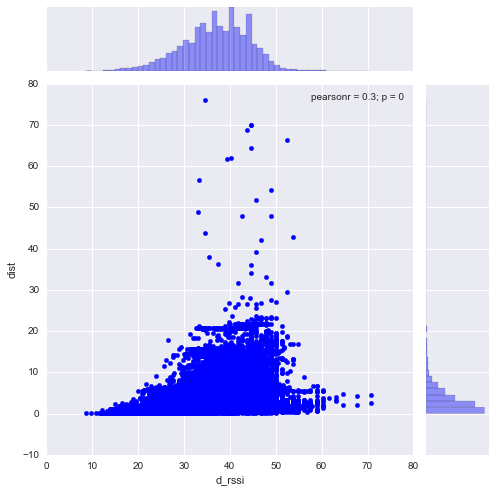

In [133]:
g = sns.jointplot("d_rssi", "dist", data=df_merge_clean, color="b", size=7)

### Certains points semblent encore atypiques ...

## Création d'un set d'entraînement

Nous proposons d'utiliser l'inverse de d_rssi (dont l'ordre de grandeur est une distance) afin de représenter par des 0 les valeurs qui correspondent à des stations "éloignées".

In [136]:
# Feature Matrix construction 

def feat_mat_const(df, bs_list, val='inv_d_rssi', fillna=0.0):
    '''
    feat_mat_const() pivots df to use "bs_list" list as a column and returns generated df.
    Input:
    df: input df
    bs_list: list of columns
    val: the column from df we want to preserve
    fillna: the value to use to replace NaN (0.0 could not be wise)
    Output:
    A df with base station id as columns.
    '''
    df_feat0 = df.pivot(index='objid', columns='bsid', values=val)
    
    df_feat = pd.DataFrame(columns=listOfBs)
    
    for col in df_feat0.columns:
        df_feat[col] = df_feat0[col]
        
    df_feat = df_feat.fillna(fillna)
    
    return df_feat

In [136]:
# Feature Matrix construction 

def distance_to_station(df_mess_train, pos_train):
    '''
    feat_mat_const() pivots df to use "bs_list" list as a column and returns generated df.
    Input:
    df: input df
    bs_list: list of columns
    val: the column from df we want to preserve
    fillna: the value to use to replace NaN (0.0 could not be wise)
    Output:
    A df with base station id as columns.
    '''
    df_feat0 = df.pivot(index='objid', columns='bsid', values=val)
    
    df_feat = pd.DataFrame(columns=listOfBs)
    
    for col in df_feat0.columns:
        df_feat[col] = df_feat0[col]
        
    df_feat = df_feat.fillna(fillna)
    
    return df_feat

In [137]:
# ground truth construction
def ground_truth_const(df_mess_train, pos_train):
    '''
    ground_truth_const() returns (latitude, longitude) from the observations
    corrsponding to objid
    '''

    temp1 = df_mess_train.copy()
    temp1[['lat', 'lng']] = pos_train
    
    temp2 = temp1.drop_duplicates('objid')[['lat', 'lng']]

    ground_truth_lat = np.array(temp2['lat'])
    ground_truth_lng = np.array(temp2['lng'])
    
    return ground_truth_lat, ground_truth_lng

In [192]:
np.max(df_merge['d_rssi'])

70.794578438413808

In [193]:
df_y_train = df_merge.drop_duplicates('objid')[['lat', 'lng']]
print("|Nombre d'observations sur le train |", len(df_y_train))

|Nombre d'observations sur le train | 6068


In [157]:
ground_truth_lat, ground_truth_lng = ground_truth_const(df_mess_train, pos_train)
ground_truth_lat.shape

(6068,)

In [159]:
# Evaluate result

def vincenty_vec(vec_coord):
    vin_vec_dist = np.zeros(vec_coord.shape[0])
    if vec_coord.shape[1] !=  4:
        print('ERROR: Bad number of columns (shall be = 4)')
    else:
        vin_vec_dist = [vincenty(vec_coord[m,0:2],vec_coord[m,2:]).meters for m in range(vec_coord.shape[0])]
    return vin_vec_dist

In [187]:

# evaluate distance error for each predicted point
def Eval_geoloc(y_train_lat , y_train_lng, y_pred_lat, y_pred_lng):
    vec_coord = np.array([y_train_lat , y_train_lng, y_pred_lat, y_pred_lng])
    err_vec = vincenty_vec(np.transpose(vec_coord))
    
    return err_vec

In [290]:
df_train = df_merge.copy()
df_train['inv_d_rssi'] = 1 / df_merge['d_rssi'].values
df_train['is_rssi'] = 1 
df_train['level_rssi'] = pd.cut(df_train.rssi, [-160, -90, -80, -70, -67, -30, 0], right=True, labels=[1,2,3,4,5,6])
df_train['level_rssi'] = df_train['level_rssi'].astype(float)

In [291]:
# df_X_train = feat_mat_const(df_train, listOfBs, val='d_rssi', fillna=71)
#df_X_train = feat_mat_const(df_train, listOfBs, val='is_rssi')

db_list = np.setdiff1d(listOfBs, listOfStangeBs)

df_X_train = feat_mat_const(df_train, db_list, val='inv_d_rssi')
print("|Nombre de messages sur le train |", len(df_X_train))

|Nombre de messages sur le train | 6068


In [292]:
df_X_train.describe()

,879,911,921,944,980,1012,1086,1092,1120,1131,...,9936,9941,9949,10134,10148,10151,10162,10999,11007,11951
count,6068.000000,6068.000000,6068.000000,6068.000000,6068.000000,6068.000000,6068.000000,6068.000000,6068.000000,6068.0,...,6068.0,6068.0,6068.0,6068.000000,6068.000000,6068.000000,6068.000000,6068.000000,6068.000000,6068.000000
mean,0.000004,0.000005,0.000004,0.000012,0.000037,0.000374,0.000238,0.000104,0.000004,0.0,...,0.0,0.0,0.0,0.000028,0.000007,0.001566,0.002722,0.000004,0.001325,0.000004
std,0.000303,0.000388,0.000322,0.000562,0.001034,0.003262,0.002266,0.001430,0.000281,0.0,...,0.0,0.0,0.0,0.000758,0.000397,0.006666,0.008438,0.000274,0.006266,0.000274
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,0.023623,0.030200,0.025119,0.030200,0.033113,0.054534,0.028510,0.021878,0.021878,0.0,...,0.0,0.0,0.0,0.023442,0.022387,0.064565,0.063096,0.021380,0.067608,0.021380


In [312]:
# Cross validation

from sklearn.model_selection import cross_val_predict
from sklearn import linear_model
from sklearn import tree
from sklearn import preprocessing
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor

#reg = tree.DecisionTreeRegressor()

reg = KNeighborsRegressor(n_neighbors=10, n_jobs=-1, leaf_size=10, p=3, weights='distance')

# Pas d'intérêt à centrer réduire
#X_train = preprocessing.scale(df_X_train.values)

y_pred_lng = cross_val_predict(reg, X_train, ground_truth_lng, cv=10, n_jobs=-1)
y_pred_lat = cross_val_predict(reg, X_train, ground_truth_lat, cv=10, n_jobs=-1)

### Meilleur candidat à ce stade :
reg = KNeighborsRegressor(n_neighbors=10, n_jobs=-1, leaf_size=10, p=3, weights='distance')

3272.9702166257912

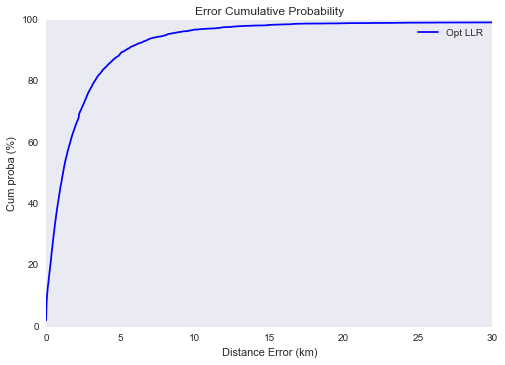

In [313]:
err_vec = Eval_geoloc(ground_truth_lat , ground_truth_lng, y_pred_lat, y_pred_lng)

# Plot error distribution

values, base = np.histogram(err_vec, bins=50000)
cumulative = np.cumsum(values) 
plt.figure();
plt.plot(base[:-1]/1000, cumulative / np.float(np.sum(values))  * 100.0, c='blue')
plt.grid(); plt.xlabel('Distance Error (km)'); plt.ylabel('Cum proba (%)'); plt.axis([0, 30, 0, 100]); 
plt.title('Error Cumulative Probability'); plt.legend( ["Opt LLR", "LLR 95", "LLR 99"])

# Error criterion

np.percentile(err_vec, 80)

In [ ]:
# Construct test prediction

df_mess_test.head()

df_feat_test = feat_mat_const(df_mess_test, listOfBs)

y_pred_lat, y_pred_lng = regressor_and_predict(df_feat, ground_truth_lat, ground_truth_lng, df_feat_test)

test_res = pd.DataFrame(np.array([y_pred_lat, y_pred_lng]).T, columns = ['lat', 'lng'])

test_res.to_csv('pred_pos_test_list.csv', index=False)

test_res.head()